In [9]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [10]:
"""
Ticker  Fund Name                           Issuer                          AUM         Expense Ratio       3-Mo TR     Segment
TSLL	Direxion Daily TSLA Bull 2X Shares	Rafferty Asset Management	    $7.86B	    0.95%	            78.9%	    Leveraged Equity: U.S. Automobile Manufacturers
""";

In [11]:
# tickers = ['TSLL', 'TSLA']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True, interval="1h")['Close']

In [12]:
# ydata.head()

In [13]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(future_stack=True)  # Removed the level parameter since there's only one level
#     .reset_index()
#     .rename(columns={0: 'Close'})  # Rename the stacked column to 'Close'
#     [['Datetime', 'Ticker', 'Close']]  # Note: column is 'Datetime', not 'Date', because of interval="1h"
#     .sort_values(by=['Datetime', 'Ticker'])
# )

# data.head(5)

In [14]:
# # time period is the min datetime of data df, converted to string in format YYYY-MM-DD
# time_period = data['Datetime'].min()

# # keep only date from time_period
# time_period = time_period.date().strftime('%Y-%m-%d')

# print(time_period)

In [15]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_TSLL_TSLA_' + time_period + '_D.csv', index=False)

In [16]:
time_period = "2023-11-10"

In [17]:
# read data from csv
data = pd.read_csv('data_TSLL_TSLA_' + time_period + '_D.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  6960 non-null   datetime64[ns, UTC]
 1   Ticker    6960 non-null   object             
 2   Close     6960 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 163.3+ KB
None
                   Datetime Ticker       Close
0 2023-11-10 14:30:00+00:00   TSLA  207.099899
1 2023-11-10 14:30:00+00:00   TSLL   11.400000
2 2023-11-10 15:30:00+00:00   TSLA  210.429993
3 2023-11-10 15:30:00+00:00   TSLL   11.687200
4 2023-11-10 16:30:00+00:00   TSLA  212.649994


In [18]:
# rename Datetime to Date, to keep consistent with previous notebooks
data = data.rename(columns={'Datetime': 'Date'})

In [19]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

# keep only date for column ym
data['ym'] = data['ym'].dt.date

data.head()

,Date,Ticker,Close,ym
0,2023-11-10 14:30:00+00:00,TSLA,207.099899,2023-11-30
1,2023-11-10 14:30:00+00:00,TSLL,11.400000,2023-11-30
2,2023-11-10 15:30:00+00:00,TSLA,210.429993,2023-11-30
3,2023-11-10 15:30:00+00:00,TSLL,11.687200,2023-11-30
4,2023-11-10 16:30:00+00:00,TSLA,212.649994,2023-11-30


In [ ]:
"""
df starts from 2023-11-10

In the next cell, this will be marked as td = 1, but actually it td = 12.

Due to this, in the next cell, I introduced a filter to keep data from a full month, 2024-10-01 onwards.
""";

In [ ]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Keep data from October 2023 onwards - make timestamp timezone-aware
data = data[data['Date'] >= pd.Timestamp(2023, 12, 1, tz='UTC')]

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

# # add data['td'] column where td is the day of the month for each Ticker
# data['td'] = data['Date'].dt.day

data.head()

,Date,Ticker,Close,ym,td
3092,2024-10-01 13:30:00+00:00,TSLA,250.130005,2024-10-31,1
3094,2024-10-01 14:30:00+00:00,TSLA,252.240005,2024-10-31,2
3096,2024-10-01 15:30:00+00:00,TSLA,255.050003,2024-10-31,3
3098,2024-10-01 16:30:00+00:00,TSLA,253.080002,2024-10-31,4
3100,2024-10-01 17:30:00+00:00,TSLA,258.670013,2024-10-31,5


In [22]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

# fill na values in ret with 0
data['ret'] = data['ret'].fillna(0)

data.head()

,Date,Ticker,Close,ym,td,ret
3092,2024-10-01 13:30:00+00:00,TSLA,250.130005,2024-10-31,1,0.000000
3094,2024-10-01 14:30:00+00:00,TSLA,252.240005,2024-10-31,2,0.008436
3096,2024-10-01 15:30:00+00:00,TSLA,255.050003,2024-10-31,3,0.011140
3098,2024-10-01 16:30:00+00:00,TSLA,253.080002,2024-10-31,4,-0.007724
3100,2024-10-01 17:30:00+00:00,TSLA,258.670013,2024-10-31,5,0.022088


In [23]:
# Filter dates and keep only needed columns

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
3092,2024-10-01 13:30:00+00:00,2024-10-31,TSLA,250.130005,0.000000,1
3094,2024-10-01 14:30:00+00:00,2024-10-31,TSLA,252.240005,0.008436,2
3096,2024-10-01 15:30:00+00:00,2024-10-31,TSLA,255.050003,0.011140,3
3098,2024-10-01 16:30:00+00:00,2024-10-31,TSLA,253.080002,-0.007724,4
3100,2024-10-01 17:30:00+00:00,2024-10-31,TSLA,258.670013,0.022088,5


In [24]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

data_ = data.copy()

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
3092,2024-10-01 13:30:00+00:00,2024-10-31,TSLA,250.130005,0.000000,1,1,0,1,0.000000,0.0,0.000000
3094,2024-10-01 14:30:00+00:00,2024-10-31,TSLA,252.240005,0.008436,2,1,0,1,0.008436,0.0,0.008436
3096,2024-10-01 15:30:00+00:00,2024-10-31,TSLA,255.050003,0.011140,3,1,0,1,0.011140,0.0,0.011140
3098,2024-10-01 16:30:00+00:00,2024-10-31,TSLA,253.080002,-0.007724,4,1,0,1,-0.007724,-0.0,-0.007724
3100,2024-10-01 17:30:00+00:00,2024-10-31,TSLA,258.670013,0.022088,5,1,0,1,0.022088,0.0,0.022088


In [25]:
# Keep only relevant return columns
data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
3092,2024-10-01 13:30:00+00:00,2024-10-31,TSLA,0.000000,0.0,0.000000
3094,2024-10-01 14:30:00+00:00,2024-10-31,TSLA,0.008436,0.0,0.008436
3096,2024-10-01 15:30:00+00:00,2024-10-31,TSLA,0.011140,0.0,0.011140
3098,2024-10-01 16:30:00+00:00,2024-10-31,TSLA,-0.007724,-0.0,-0.007724
3100,2024-10-01 17:30:00+00:00,2024-10-31,TSLA,0.022088,0.0,0.022088


In [26]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_TSLL)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

# count of nan values in each column
nan = pivoted.isna().sum()
print(nan)

# fill missing values with 0
pivoted = pivoted.fillna(0)

pivoted.head()

Date            0
ym              0
TSLA_ret_som    0
TSLL_ret_som    0
TSLA_ret_eom    0
TSLL_ret_eom    0
TSLA_ret_nsm    0
TSLL_ret_nsm    0
dtype: int64


,Date,ym,TSLA_ret_som,TSLL_ret_som,TSLA_ret_eom,TSLL_ret_eom,TSLA_ret_nsm,TSLL_ret_nsm
0,2024-10-01 13:30:00+00:00,2024-10-31,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,2024-10-01 14:30:00+00:00,2024-10-31,0.008436,0.017433,0.0,0.0,0.008436,0.017433
2,2024-10-01 15:30:00+00:00,2024-10-31,0.011140,0.022959,0.0,0.0,0.011140,0.022959
3,2024-10-01 16:30:00+00:00,2024-10-31,-0.007724,-0.016232,-0.0,-0.0,-0.007724,-0.016232
4,2024-10-01 17:30:00+00:00,2024-10-31,0.022088,0.046697,0.0,0.0,0.022088,0.046697


In [27]:
# create a copy of data to be later used for the backtest analysis (8 PL streams in the backtesting)
backtest_data = pivoted.copy()

In [28]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['TSLL_ret'] = pivoted['TSLL_ret_som'] + pivoted['TSLL_ret_eom']
pivoted['TSLL_TSLA_som'] = pivoted['TSLL_ret_som'] - pivoted['TSLA_ret_som']
pivoted['TSLL_TSLA_eom'] = pivoted['TSLL_ret_eom'] - pivoted['TSLA_ret_eom']
pivoted['TSLL_TSLA_nsm'] = pivoted['TSLL_ret_nsm'] - pivoted['TSLA_ret_nsm']

# Add TSLA returns to pivoted
pivoted['TSLA_ret'] = pivoted['TSLA_ret_som'] + pivoted['TSLA_ret_eom']

# Select relevant columns
returns = pivoted[['ym', 'TSLL_ret', 'TSLA_ret', 'TSLL_TSLA_som', 'TSLL_TSLA_eom', 'TSLL_TSLA_nsm']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,TSLL_ret,TSLA_ret,TSLL_TSLA_som,TSLL_TSLA_eom,TSLL_TSLA_nsm
ym,,,,,
2024-10-31,-0.060618,-0.001400,-0.013033,-0.009903,0.037147
2024-11-30,0.748629,0.360197,0.003434,0.339375,-0.006619
2024-12-31,0.326097,0.188050,0.034215,0.112305,0.047775
2025-01-31,-0.029101,0.002329,0.025943,-0.033016,-0.065334
2025-02-28,-0.496441,-0.275026,-0.059682,-0.239011,-0.052202


In [29]:
monthly.tail(5)

,TSLL_ret,TSLA_ret,TSLL_TSLA_som,TSLL_TSLA_eom,TSLL_TSLA_nsm
ym,,,,,
2025-07-31,-0.094412,-0.029690,-0.015428,-0.025261,-0.053666
2025-08-31,0.149135,0.083650,-0.002922,0.075715,-0.016753
2025-09-30,0.717657,0.331078,-0.000394,0.315796,-0.017286
2025-10-31,0.020133,0.026949,-0.040770,0.055662,0.032334
2025-11-30,-0.123984,-0.059450,-0.033175,-0.031988,0.020873


In [30]:
return_data = monthly.copy()

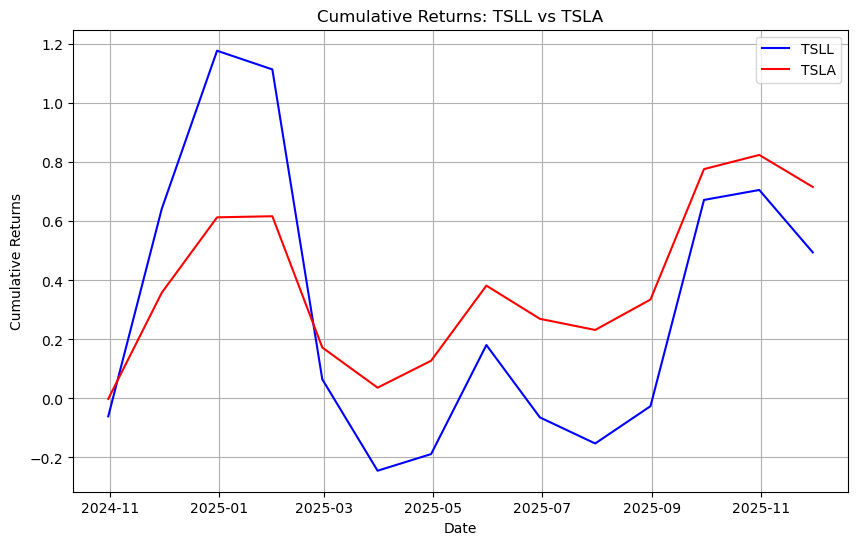

In [31]:
# calculate cumulative returns for TSLL_ret and TSLA_ret
monthly['TSLL_cumret'] = (1 + monthly['TSLL_ret']).cumprod() - 1
monthly['TSLA_cumret'] = (1 + monthly['TSLA_ret']).cumprod() - 1

# plot TSLL_ret vs TSLA_ret to compare their performance
plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['TSLL_cumret'], label='TSLL', color='blue')
plt.plot(monthly.index, monthly['TSLA_cumret'], label='TSLA', color='red')
plt.title('Cumulative Returns: TSLL vs TSLA')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

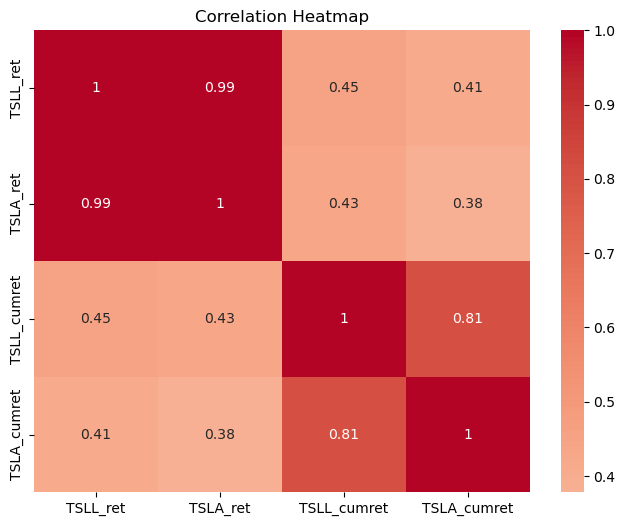

In [32]:
# plot correlation heatmap of TSLL_ret, TSLA_ret, TSLL_cumret, TSLA_cumret
plt.figure(figsize=(8, 6))
sns.heatmap(monthly[['TSLL_ret', 'TSLA_ret', 'TSLL_cumret', 'TSLA_cumret']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

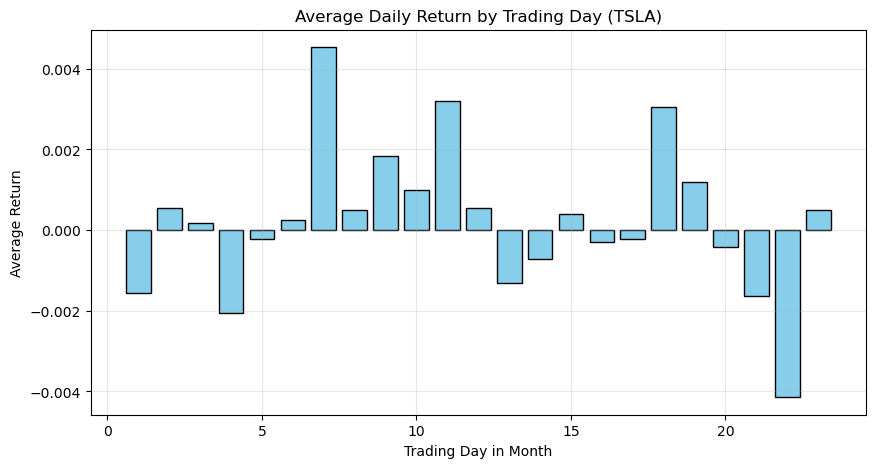

,td,ret
18,19,0.001202
19,20,-0.000422
20,21,-0.001623
21,22,-0.004143
22,23,0.000487


In [33]:
# Average daily returns of TSLA and TSLL
# Keep only rows where the ticker is 'TSLA' 
TSLA = data[data['Ticker'] == 'TSLA'].copy()

# Add 'ym' column as the end of the month for each date 
TSLA['ym'] = TSLA['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price 
TSLA['ret'] = TSLA['Close'].pct_change()

TSLA_filtered = TSLA.copy()

# For each month, number the days starting from 1 
TSLA_filtered['td'] = TSLA_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns 
avg_daily_returns = TSLA_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib 
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns['td'], avg_daily_returns['ret'], color='skyblue', edgecolor='black')

# Add labels and title 
plt.title("Average Daily Return by Trading Day (TSLA)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference 
avg_daily_returns.tail()

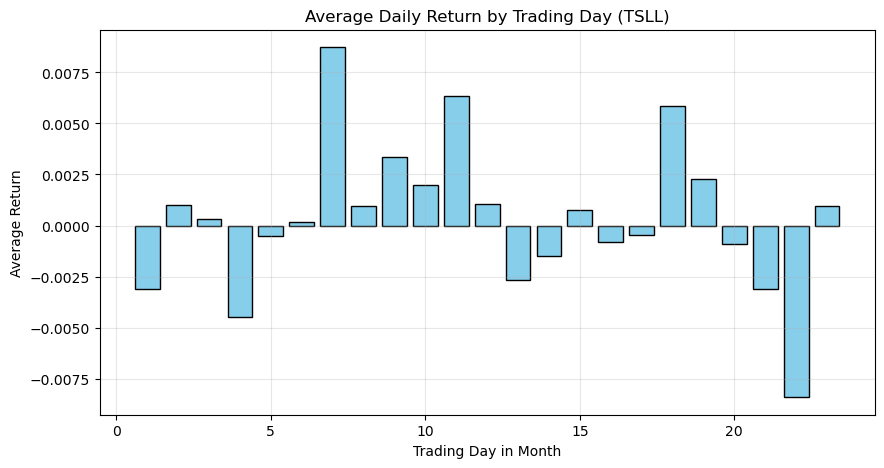

,td,ret
18,19,0.002297
19,20,-0.000905
20,21,-0.003105
21,22,-0.008409
22,23,0.000953


In [ ]:
# Keep only rows where the ticker is 'TSLL'
TSLL = data[data['Ticker'] == 'TSLL'].copy()

# Add 'ym' column as the end of the month for each date
TSLL['ym'] = TSLL['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price
TSLL['ret'] = TSLL['Close'].pct_change()

# Keep only data after ...
TSLL_filtered = TSLL[TSLL['Date'] >= pd.Timestamp(2023, 12, 1, tz='UTC')].copy()

# For each month, number the days starting from 1
TSLL_filtered['td'] = TSLL_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns
avg_daily_returns_TSLL = TSLL_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns_TSLL['td'], avg_daily_returns_TSLL['ret'], color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Average Daily Return by Trading Day (TSLL)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference
avg_daily_returns_TSLL.tail()

In [35]:
# drop ret	td	som_flag	eom_flag	nsm_flag	ret_som	ret_eom	ret_nsm from data_
data_ = data_.drop(columns=['ret', 'td', 'som_flag', 'eom_flag', 'nsm_flag', 'ret_som', 'ret_eom', 'ret_nsm'])

# pivot data_.Ticker
pivoted_data_ = data_.pivot(index='Date', columns='Ticker', values='Close')

In [36]:
# split DatetimeIndex index into Date and Time columns
pivoted_data_ = pivoted_data_.reset_index()

# Store the original datetime before converting
original_datetime = pivoted_data_['Date']

# Extract date and time from the original datetime column
pivoted_data_['Date'] = original_datetime.dt.date
pivoted_data_['Time'] = original_datetime.dt.time

# add pct_change columns for each Ticker
pivoted_data_['TSLL_pct_change'] = pivoted_data_['TSLL'].pct_change()
pivoted_data_['TSLA_pct_change'] = pivoted_data_['TSLA'].pct_change()

# fill na values with 0
pivoted_data_['TSLL_pct_change'] = pivoted_data_['TSLL_pct_change'].fillna(0)
pivoted_data_['TSLA_pct_change'] = pivoted_data_['TSLA_pct_change'].fillna(0)

pivoted_data_.head()

Ticker,Date,TSLA,TSLL,Time,TSLL_pct_change,TSLA_pct_change
0,2024-10-01,250.130005,12.6200,13:30:00,0.000000,0.000000
1,2024-10-01,252.240005,12.8400,14:30:00,0.017433,0.008436
2,2024-10-01,255.050003,13.1348,15:30:00,0.022959,0.011140
3,2024-10-01,253.080002,12.9216,16:30:00,-0.016232,-0.007724
4,2024-10-01,258.670013,13.5250,17:30:00,0.046697,0.022088


In [37]:
# Group by the hour and take the mean of returns 
avg_daily_returns = pivoted_data_.groupby('Time')[['TSLL_pct_change', 'TSLA_pct_change']].mean().reset_index()

avg_daily_returns.head(10)

Ticker,Time,TSLL_pct_change,TSLA_pct_change
0,13:30:00,0.003031,0.001645
1,14:30:00,0.002580,0.001445
2,15:30:00,0.000411,0.000228
3,16:30:00,-0.000889,-0.000406
4,17:30:00,0.001682,0.000842
5,18:30:00,-0.001822,-0.000817
6,19:30:00,0.000454,0.000249
7,20:30:00,0.000796,0.000349


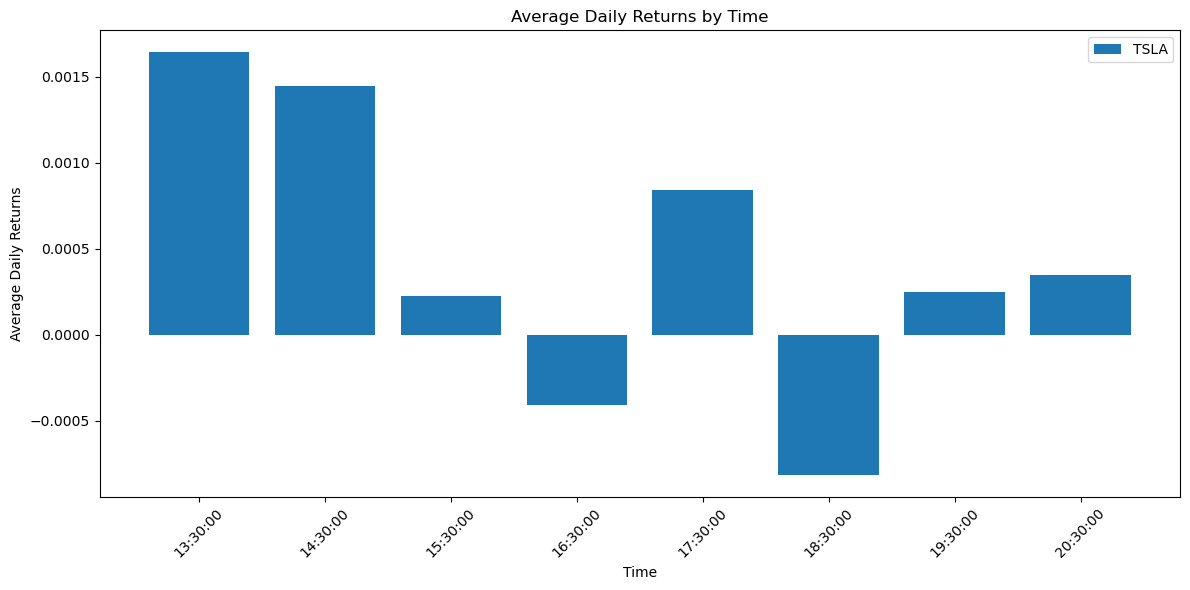

In [38]:
# plot avg_daily_returns by Time, using matplotlib
plt.figure(figsize=(12, 6))

# Convert time to string for plotting
time_strings = avg_daily_returns['Time'].astype(str)

# plt.bar(time_strings, avg_daily_returns['TSLL_pct_change'], label='TSLL')
plt.bar(time_strings, avg_daily_returns['TSLA_pct_change'], label='TSLA')
plt.xlabel('Time')
plt.ylabel('Average Daily Returns')
plt.title('Average Daily Returns by Time')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

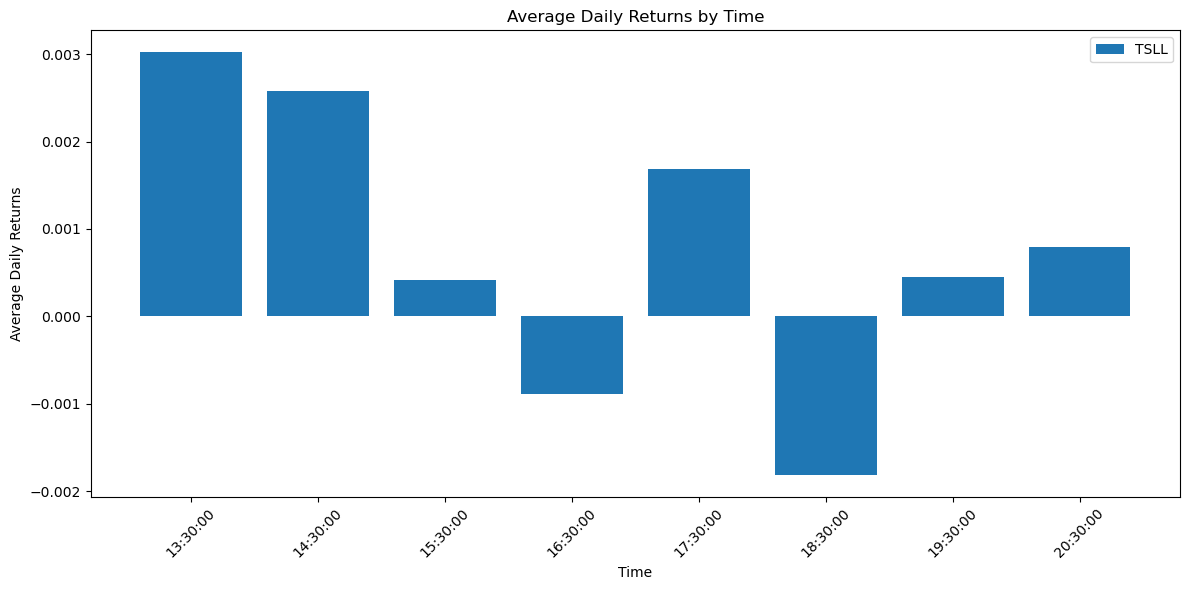

In [39]:
# plot avg_daily_returns by Time, using matplotlib
plt.figure(figsize=(12, 6))

# Convert time to string for plotting
time_strings = avg_daily_returns['Time'].astype(str)

plt.bar(time_strings, avg_daily_returns['TSLL_pct_change'], label='TSLL')
# plt.bar(time_strings, avg_daily_returns['TSLA_pct_change'], label='TSLA')
plt.xlabel('Time')
plt.ylabel('Average Daily Returns')
plt.title('Average Daily Returns by Time')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

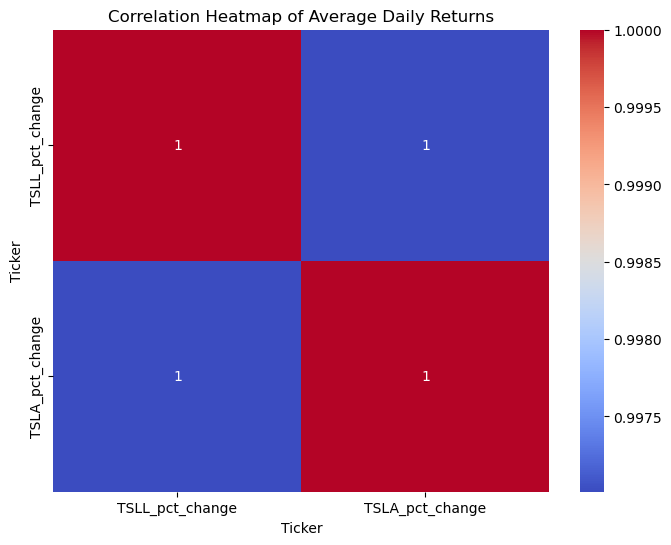

In [40]:
# correlation heatmap of avg_daily_returns
plt.figure(figsize=(8, 6))
sns.heatmap(avg_daily_returns[['TSLL_pct_change', 'TSLA_pct_change']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Average Daily Returns')
plt.show()